# **Solving 1D Burger's Equation** $$\frac{∂u}{∂t}+u\frac{∂u}{\partial x} = ν\frac{∂^2u}{\partial x^2} \text{ with } u(-1,t) = u(1,t) = 0 \text{ and }u(x,0) = \sin{(\pi x)}.$$

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

## **1. Defining the Neural Network**

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),#starting with 2 components namely x and t but it will expand into 20 neurons
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x): #specifies how the data flows through the network (i.e., it defines the forward pass of the network).
        out = self.net(x)
        return out

## **2. Visualization of the Neural Network**

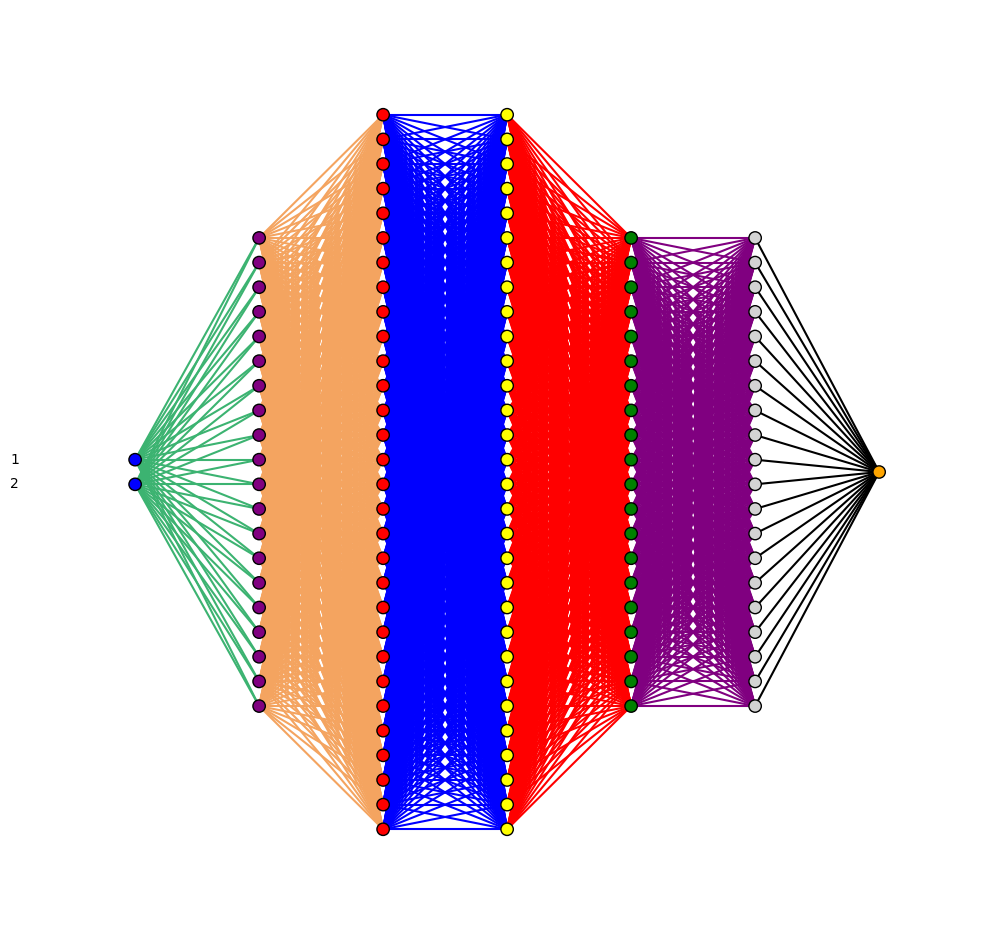

In [3]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib with different colors for each layer and the edges.

    :param ax: matplotlib.axes.Axes instance
    :param left, right, bottom, top: Coordinates of the bounding box
    :param layer_sizes: List containing the number of neurons in each layer
    '''
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)

    # Define different colors for each layer and edges
    layer_colors = ['blue', 'purple', 'red', 'yellow', 'green', 'lightgray','orange']
    edge_colors = ['mediumseagreen', 'sandybrown', 'blue', 'red', 'purple', 'black']

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color=layer_colors[n % len(layer_colors)], ec='k', zorder=4)
            ax.add_artist(circle)
            # Label only the first layer
            if n == 0:
                plt.text(left - 0.125, layer_top - m*v_spacing, str(m + 1), ha='right', va='center')

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing],
                                  c=edge_colors[n % len(edge_colors)])
                ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [2, 20, 30, 30, 20, 20, 1])
plt.show()




## **3. Neural Network for PDE Solver: Initialization, Training, and Evaluation**

In [4]:
class Net:
    def __init__(self):
        # Set the device to GPU if available, else CPU
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        # Initialize the neural network model and move it to the chosen device
        self.model = NN().to(device)

        # Computational domain setup
        # Define step sizes in space (self.h) and time (self.k)
        self.h = 0.1
        self.k = 0.1
        # Create tensors for space and time dimensions
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)
        # Create a grid of points in the computational domain
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # Training data setup
        # Define boundary conditions at the start and end of the space dimension
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        # Define initial condition at the start of the time dimension
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        # Combine boundary and initial conditions
        self.X_train = torch.cat([bc1, bc2, ic])

        # Define the corresponding y-values for boundary and initial conditions
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        # Move tensors to the chosen device
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        # Enable gradient calculation for X
        self.X.requires_grad = True

        # Optimizer setup
        # Initialize the Adam optimizer
        self.adam = torch.optim.Adam(self.model.parameters())
        # Initialize the L-BFGS optimizer with specified parameters
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        # Loss function setup
        self.criterion = torch.nn.MSELoss()
        # Iteration counter
        self.iter = 1

    def loss_func(self):
        # Reset gradient buffers
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Forward pass for training data and compute data loss
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # Forward pass for computational domain
        u = self.model(self.X)

        # Compute gradients of u with respect to X
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        # Extract time and space derivatives
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]

        # Compute second derivative of u with respect to space
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs=torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True
        )[0]

        du_dxx = du_dXX[:, 0]

        # Compute PDE loss
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, (0.01 / math.pi) * du_dxx)

        # Total loss is the sum of data loss and PDE loss
        loss = loss_pde + loss_data
        # Backpropagation
        loss.backward()

        # Print loss every 100 iterations
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        # Increment iteration counter
        self.iter = self.iter + 1

        return loss

    def train(self):
        # Set the model to training mode
        self.model.train()
        # Run the Adam optimizer for a fixed number of iterations
        for i in range(1000):
            self.adam.step(self.loss_func)
        # Run a step of the L-BFGS optimizer
        self.optimizer.step(self.loss_func)

    def eval_(self):
        # Set the model to evaluation mode
        self.model.eval()


In [5]:
# training
net = Net()
net.train()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.17735275626182556
200 0.11290951073169708
300 0.07277245819568634
400 0.049299899488687515
500 0.027873601764440536
600 0.0430188924074173
700 0.015139399096369743
800 0.011472911573946476
900 0.01023804396390915
1000 0.009893214330077171
1100 0.002826495561748743
1200 0.0012963959015905857
1300 0.0006014095270074904
1400 0.00039063888834789395
1500 0.00027959796716459095
1600 0.00022204781998880208
1700 0.0001855323207564652
1800 0.00014648442447651178
1900 0.00012221453653182834
2000 0.00010819517774507403
2100 9.629104897612706e-05
2200 8.242498734034598e-05
2300 6.94379341439344e-05
2400 6.053116521798074e-05
2500 5.435731873149052e-05
2600 4.606039874488488e-05
2700 4.164066558587365e-05
2800 3.968559030909091e-05
2900 3.760543040698394e-05
3000 3.613000444602221e-05
3100 3.4228669392177835e-05
3200 3.2736534194555134e-05
3300 3.066047793254256e-05
3400 2.9590395570266992e-05
3500 2.8027541702613235e-05
3600 2.693482929316815e-05
3700 2.5636458303779364e-05
3800 2.4322918761

In [6]:
# Set the model to evaluation mode
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

# **4. Visualizaion of the Results**

In [7]:
# @title
# Set step sizes in space (h) and time (k)
h = 0.01
k = 0.01

# Create tensors for space (x) and time (t) dimensions
x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

# Create a grid of points in the space-time domain
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

# Move the grid to the same device as the network's training data
X = X.to(net.X.device)

In [8]:
# Get the model from 'net' and set it to evaluation mode
model = net.model
model.eval()

# Disable gradient calculations for performance
with torch.no_grad():
    # Forward pass through the model to get predictions
    y_pred = model(X)
    # Reshape the output to match the dimensions of the space-time grid
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [9]:
# Set the style of the plot to 'white'
sns.set_style("white")

# Create a figure for plotting with high resolution (3000 DPI)
plt.figure(figsize=(5, 3), dpi=3000)

# Create a heatmap of the predictions using the 'jet' colormap
sns.heatmap(y_pred, cmap='jet')
plt.xlabel('Time')
plt.ylabel('Space')

Text(1012.6666666666666, 0.5, 'Space')

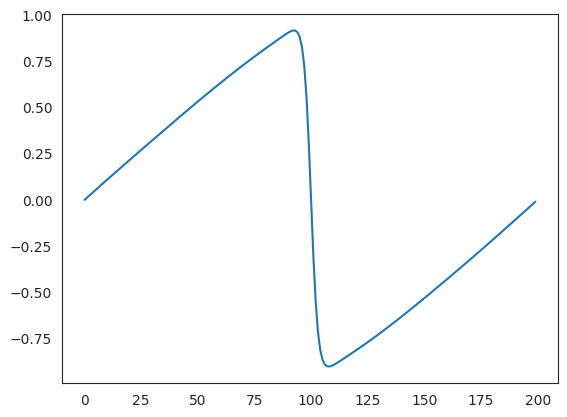

In [10]:
plt.plot(y_pred[:,60])


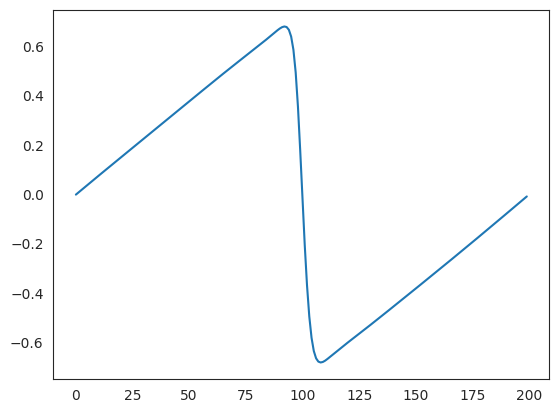

In [11]:
plt.plot(y_pred[:,-1])